In [220]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

from sklearn.linear_model import LinearRegression

In [2]:
csv_file = 'data/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'RH']
full = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'rh']

#bad_dates = ['2019-08-21', '2019-08-22', '2019-09-24']
#GA = full.loc[(full['id'] == 'GA1') & (~full['date'].isin(bad_dates)) , :]
AK = full.loc[full['id'] == 'AK1', :].copy()

In [3]:
outlier_czs = [34105, 34113, 34112, 34106]

def subset_and_rename_A(df):
    df = df[['aum', 'frac_traveltime_lt15', 'gini',
    'rel_tot', 'cs_fam_wkidsinglemom', 'taxrate',
     'frac_worked1416', 'cs_born_foreign', 'region']]
    df.columns = ['aum', 'travel_lt15', 'gini', 
                  'rel_tot', 'single_mom', 'taxrate', 
                  'worked_14', 'foreign', 'region'] 
    return df

regions = (
    pd.read_csv('data/census_regions.csv',
                header=0, names=['state', 'stateabbrv', 'region', 'div'])
    .drop(columns=['div'])
)

cz_df = (pd.read_csv('data/mobility.csv')
         .query('not aum.isnull()', engine='python')
         .query('cz not in @outlier_czs')
         .merge(regions, on='stateabbrv')
         .pipe(subset_and_rename_A)
        )


In [221]:
sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)


def make_lamorinda(sfh):
    return sfh.replace({
        'city': {
            'Lafayette': 'Lamorinda',
            'Moraga': 'Lamorinda',
            'Orinda': 'Lamorinda',
        }
    })

four_cities = ['Berkeley', 'Lamorinda', 'Piedmont', 'Richmond']

def parse_dates(sfh):
    dates = pd.to_datetime(sfh['date'], infer_datetime_format=True)
    return sfh.assign(dates=dates).set_index('date')


def subset(df):
    return df.loc[(df['price'] < 4000000) &
                  (df['bsqft'] < 12000) &
                  (df['lsqft'] < 100000) &
                  (df['city'].str.contains("Berkeley|Piedmont|Richmond|Lamorinda")) &
                  (df['dates'] > '2005-12-31') &
                  (df['dates'] <= '2006-12-31')
                 ]

def log_vals(sfh):
    return sfh.assign(log_price=np.log10(sfh['price']),
                      log_bsqft=np.log10(sfh['bsqft']),
                      log_lsqft=np.log10(sfh['lsqft']))

def clip_br(sfh):
    six_up = sfh.loc[sfh['br'] >=6, 'br'].unique()
    new_bed = sfh['br'].replace(six_up, 6)
    return sfh.assign(br=new_bed)

def compute_ppsf(sfh):
    return sfh.assign(
    ppsf=sfh['price'] / sfh['bsqft'], 
    log_ppsf=lambda df: np.log10(df['ppsf']))


sfh = (sfh_all
 .pipe(make_lamorinda)
 .pipe(parse_dates)
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
 .pipe(compute_ppsf) 
)


b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


In [222]:
var_na = ['log_price', 'log_lsqft', 'log_bsqft', 'br']

sfh = sfh.dropna(subset=var_na)

sfh.drop(["dates","county", "zip","street","year","datesold"], axis = 1, inplace=True)

# Feature Engineering

All of the models that we have fit so far in this chapter have used existing numeric features from a data frame. In this section, we look at two other types of explanatory variables: those that are transformations of numeric variables and categorical variables. Creating transformations of variables is called *feature engineering*.

We first introduced feature engineering in {numref}`Chapter %s <ch:cleaning>` and {numref}`Chapter %s <ch:eda>`. There, we transformed variables so that they had more symmetric distributions.  Transformed features can capture more kinds of patterns in the data and lead to better and more accurate models.

We return to the data set we used as an example in {numref}`Chapter %s <ch:eda>` on house sale prices in the San Francisco Bay area to demonstrate how to use transformed features in linear models. This time, we restrict the data to houses sold in 2006, when sale prices were relatively stable, so we don't need to account for trends in price over time.

We wish to model sale price. Earlier, visualizations showed us that sale price was related to several features collected in the data frame, like the size of the house, the size of the lot, number of bedrooms, and the city. We transformed both sale price and the size of the house to improve their relationship, and we saw that box plots of sale price by the number of bedrooms, and box plots by city revealed interesting relationships. In this section, we show how to include transformed numeric features, an ordinal feature (the number of bedrooms), and nominal feature (the city) in a linear model.  

We begin by incorporating log transformed features in a model for sale price. 
The correlation matrix tell us which of our numeric explanatory variables (original and transformed) is most strongly correlated with sale price.

In [230]:
sfh.corr()

,price,br,lsqft,bsqft,...,log_bsqft,log_lsqft,ppsf,log_ppsf
price,1.00,0.45,0.59,0.79,...,0.74,0.62,0.49,0.47
br,0.45,1.00,0.29,0.67,...,0.71,0.38,-0.18,-0.21
lsqft,0.59,0.29,1.00,0.46,...,0.44,0.85,0.29,0.27
...,...,...,...,...,...,...,...,...,...
log_lsqft,0.62,0.38,0.85,0.52,...,0.52,1.00,0.29,0.27
ppsf,0.49,-0.18,0.29,-0.08,...,-0.11,0.29,1.00,0.96
log_ppsf,0.47,-0.21,0.27,-0.10,...,-0.14,0.27,0.96,1.00


Sale price correlates most highly with house size, called `bsqft` for building square feet. We make a scatter plot of sale price against house size to confirm the association is linear.   

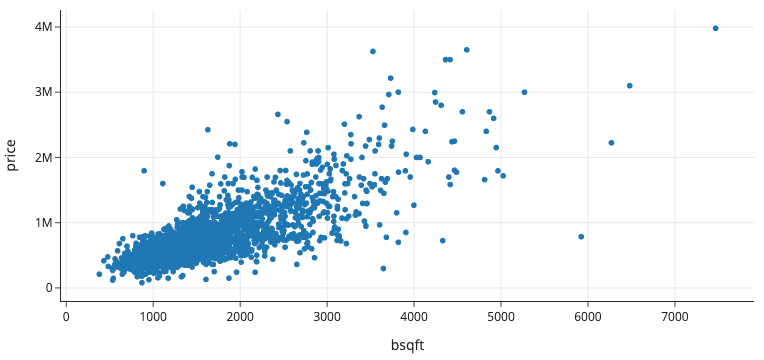

In [228]:
fig = px.scatter(sfh, x="bsqft", y="price",
                 width=450, height=250)

fig

The relationship does look roughly linear, but the very large and expensive houses are far from the center of the distribution and can overly influence the model fit. As shown in {numref}`Chapter %s <ch:eda>`, the log transformation makes the distributions of price and size more symmetric (both are log base 10 to make it easier to convert the values into the original units).

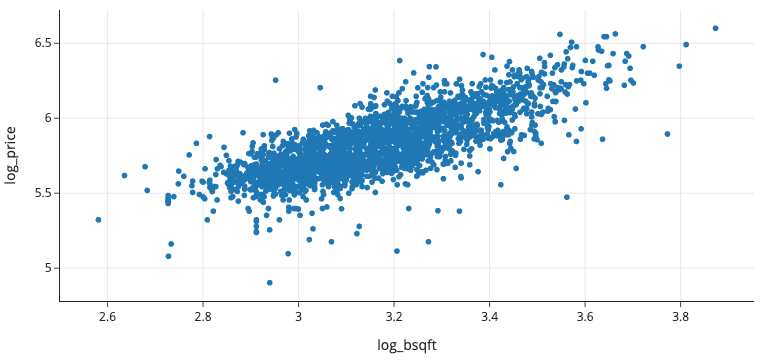

In [229]:
fig = px.scatter(sfh, x="log_bsqft", y="log_price",
                 width=450, height=250)

fig

Ideally, a transformation should make sense in the context of the data. If we fit a simple linear model for log(price) based on log(size), this implies that, say, a 10% increase in house size is associated with a $\theta * 10$% change in sale price. Or, if the model relates log-transformed price to the number of bedrooms, then one additional bedroom is associated with a $\theta$ percent change in sale price. Both of these models make sense in the context of house sale prices so we fit them.

Let's begin by fitting a model that explains log-transformed price by the house's log-transformed size. But first, we note that this model is still considered a linear model. If we represent sale price by $y$ and house size by $x$, then the model is

$$
\begin{aligned}
\log(y) ~&=~ \theta_0 + \theta_1\log(x) 
\end{aligned}
$$

Note that we have ignored the variation around the line in this equation to make the linear relationship clearer. This equation may not seem linear, but, if we rename $\log(y)$ to $w$ and $\log(x)$ to $v$, then we can express the "log-log" relationship as a linear model:

$$
w ~=~ \theta_0 + \theta_1 v
$$

That is, this model is linear in the log-transformed variables, $\log(y)$ and $\log(x)$.

Other examples of models that can be expressed as linear combinations of transformed features appear below.

$$
\begin{aligned}
\log(y) ~&=~ \theta_0 + \theta_1 x \\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 x^2 \\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 z  + \theta_3 x z  
\end{aligned}
$$

Again, if we rename $\log(y)$ to $w$, $x^2$ to $u$, and $x z$ as $t$, then we can express each of the above models as linear in these renamed features. The above models are now, in order,  

$$
\begin{aligned}
w ~&=~ \theta_0 + \theta_1 x \\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 u\\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 z  + \theta_3 t \\ 
\end{aligned}
$$

In short, we think of models that include nonlinear transformations of features and/or combinations of features as linear in their derived features. In practice, we don't rename the transformed features when we describe the model; instead, we write the model using the transformations of the original features because it's important to keep track of the transformations, especially when interpreting the coefficients.

When we refer to these models, we include mention of the transformations. That is, we call a model log-log when both the outcome and explanatory variables are log-transformed; we say it's log-linear when the outcome is log-transformed but not the explanatory variable; we describe a model as having polynomial features of, say degree 2, when the first and second power transformation of the explanatory variable are included; and we say a model include an interaction term between two explanatory features when the product of these two features is included in the model.

Let's fit a log-log model of price on size.

In [326]:
X1_log = sfh[['log_bsqft']]    
y_log = sfh[['log_price']]
model1_log_log = LinearRegression().fit(X1_log, y_log)

The coefficients and predicted values from this model cannot be directly compared to a model fitted using linear features because the units of the variables in this model the log of dollars and log of square feet, not dollars and square feet. 

In [327]:
print(f"Model log(price) ~ log(building size):\n Intercept (log $): {model1_log_log.intercept_}\n",
      f"Coefficient of building size (log $/log ft^2): {model1_log_log.coef_}")

Model log(price) ~ log(building size):
 Intercept (log $): [2.97]
 Coefficient of building size (log $/log ft^2): [[0.9]]


Next, we compute the predicted values and residuals and examine them with a plot.

In [328]:
predicted = model1_log_log.predict(X1_log)
errors = y_log - predicted 

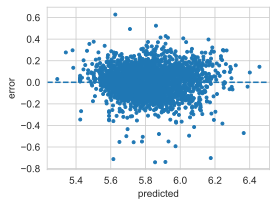

In [329]:
plt.plot(predicted, errors, '.')
plt.xlabel("predicted")
plt.ylabel("error")
#plt.ylim((-20, 20))
plt.axhline(y=0, linestyle='dashed')

The residual plot looks reasonable, but it contains thousands of points which makes it hard to see curvature. 

To see if additional variables might be helpful, we can plot the residuals from the fitted model against a variable that is not in the model. If we see patterns, that indicates we might want to include this additional feature, or a transformation of it, in the model. Earlier we saw that the distribution of price was related to the city where the house is located so let's examine the relationship between the residuals and city with a box plot.

In [295]:
sfh = sfh.assign(errors1_log=errors)

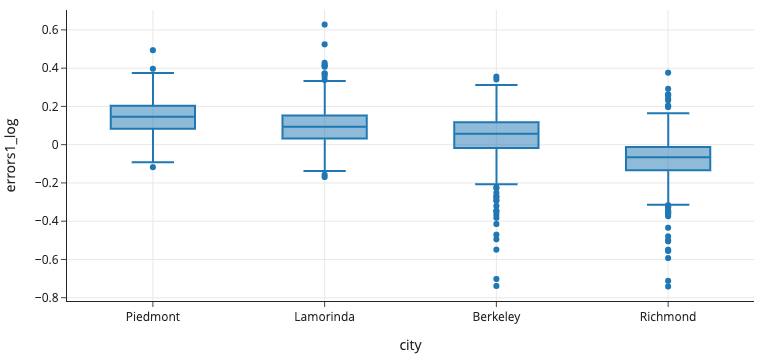

In [299]:
fig = px.box(sfh, x='city', y='errors1_log',
            category_orders={"city":["Piedmont","Lamorinda","Berkeley", "Richmond"]})

fig

This plot shows us that the distribution of errors appear to be shifted  for each city. Ideally, the median of each city's box plot lines up with 0. Instead, we see that houses sold in  Piedmont have over 75% positive errors, meaning the actual sale price is above the predicted value. And at the other extreme, roughly 75% of sale prices in Richmond fall below their predicted values. These patterns suggest that we should include location in the model. From a context point of view, it makes sense for location to impact sale price. In the next section, we show how to incorporate a nominal variable in a linear model. 

## Categorical Features 

The first model we fit, was the constant model that we fitted in {numref}`Chapter %s <ch:constant>`. There we minimized squared loss to find the best fitting constant:

$$
\min_c \sum_i (y_i - c)^2
$$

We can think of including a nominal feature in a model in a similar way. That is, we find the best fitting constant to each subgroup of the data. In other words 

$$
\begin{aligned}
\min_{c_B} \sum_{i \in \textrm{Berkeley}} (y_i - c_B)^2
~~~&~~~  \min_{c_L} \sum_{i \in \textrm{Lamorinda}} (y_i - c_L)^2 \\
 \min_{c_P} \sum_{i \in \textrm{Piedmont}} (y_i - c_P)^2 
~~~&~~~ \min_{c_R} \sum_{i \in \textrm{Richmond}} (y_i - c_R)^2 
\end{aligned}
$$

A much simpler way to describe this model is with *one hot encoding*. 


One-hot encoding takes a categorical feature and creates multiple numeric
features that have only 0 and 1 values.
To do a one-hot encoding, we create new features that each correspond to
one unique category.
In this case, we have four cities:
Berkeley, Lamorinda, Piedmont, and Richmond.
Since we have four categories, we create four new features in the design
matrix $ X_oh $.
Each row in $ X_oh $ contains one value 1 in the column that matches the
city, and all of the other columns are 0.
We illustrated this process in {numref}`Figure %s <fig:one-hot2>`.

```{figure} figures/one-hot.svg
---
name: fig:one-hot2
width: 100%
---

One-hot encoding for a small example dataset (left) and its resulting design matrix (right).
```

Now we can concisely represent the model as follows:

$$
y_i ~\approx~ \theta_B x_{i,B} ~+~ \theta_L x_{i,L} \\
~~~~~~~~~~ ~+~ \theta_P x_{i,P} ~+~ \theta_R x_{i,R}
$$
Here, we have indexed the columns of the design matrix by $B$, $L$, $P$, and $R$ rather than by $j$ to make it clear that each column represents a column of 0s and 1s where, say, a 1 appears for $x_{i,P}$ if the $i$th house is located in Piedmont. 

We now minimize least square loss over the $\theta$s,

$$
\begin{aligned}
\| \mathbf{y} - \textbf{X}\boldsymbol{\theta} \|^2 &=
\sum_i (y_i - \theta_B x_{i,B} ~+~ \theta_L x_{i,L}  ~+~ \theta_P x_{i,P} ~+~ \theta_R x_{i,R})^2 \\
& = \sum_{i \in Berkeley} (y_i - \theta_B x_{i,B})^2 ~+~ \sum_{i \in Lamorinda} (y_i -\theta_L x_{i,L})^2 \\
& ~~+~ \sum_{i \in Piedmont} (y_i -\theta_P x_{i,P})^2 ~+~ \sum_{i \in Richmond} (y_i -\theta_R x_{i,R})^2 
\end{aligned}
$$
where $\boldsymbol{\theta}$ is the column vector $[\theta_B, \theta_L, \theta_P, \theta_R]$. 

We use `OneHotEncoder` to create this design matrix.

In [336]:
enc = OneHotEncoder(
    # categories argument sets column order
    categories=[["Berkeley", "Lamorinda", "Piedmont", "Richmond"]],
   # drop='first',
    sparse=False,
)

X_city = enc.fit_transform(sfh[['city']])

categories_city=["Berkeley","Lamorinda", "Piedmont", "Richmond"]
X_city_df = pd.DataFrame(X_city, columns=categories_city)
X_city_df

,Berkeley,Lamorinda,Piedmont,Richmond
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
...,...,...,...,...
2664,0.0,0.0,0.0,1.0
2665,0.0,0.0,0.0,1.0
2666,0.0,0.0,0.0,1.0


We fit a model using these one-hot encoded features. 

In [337]:
model_city = LinearRegression(fit_intercept=False).fit(X_city_df, y_log_price)

And, we examine the multiple $R^2$.

In [338]:
print(f"R-square for city model: {model_city.score(X_city_df, y_log_price):.2f}\n")

R-square for city model: 0.57



With knowing only the location of the house, we can do a reasonably good job of estimating the logarithm of sale price. Below are the coefficients of the fit.

In [339]:
model_city.coef_

array([[5.87, 6.03, 6.1 , 5.67]])

The estimated sale price (in log $) depend on the city as expected from the box plots. But, if we know the size of the house, we should be able to make an even better model. We saw earlier that the simple log-log model that explains sale price by house size does reasonably well so adding the location of the house to the model should further improve it. 

Such a model looks 

$$
y_i ~\approx~ \theta_1x_i +  \theta_B x_{i,B} ~+~ \theta_L x_{i,L} \\
~~~~~~~~~~ ~+~ \theta_P x_{i,P} ~+~ \theta_R x_{i,R}
$$

Notice that this model describes the relationship between log(price), which is represented as $y$ and log(size), which is represented as $x$, as linear with the same slope for each city.
But, the intercept term depends on the city.

$$
\begin{aligned}
y_i ~&\approx~ \theta_1x_i +  \theta_B x_{i,B} ~~&\textrm{for houses in Berkeley} \\
y_i ~&\approx~ \theta_1x_i + \theta_L x_{i,L} ~~&\textrm{for houses in Lamorinda}\\
y_i ~&\approx~ \theta_1x_i + \theta_P x_{i,P} ~~&\textrm{for houses in Piedmont}\\
y_i ~&\approx~ \theta_1x_i + \theta_R x_{i,R} ~~&\textrm{for houses in Richmond}
\end{aligned}
$$

We make a facet of scatter plots, one for each city, to see if this relationship roughly holds.

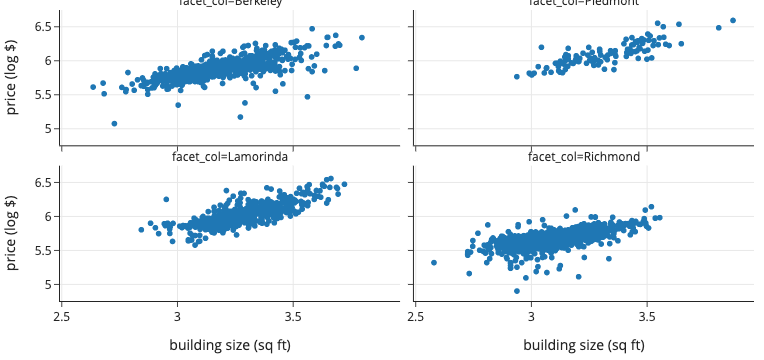

In [300]:
fig = px.scatter(x=sfh['log_bsqft'], y=sfh['log_price'], 
                 facet_col=sfh['city'], facet_col_wrap=2,
                labels={
                     "y": "price (log $)",
                     "x": "building size (sq ft)"},)
fig

The shift is evident in the scatter plot, but it may be the case that the slopes are also different. We concatenate our two design matrices together to fit the model. 

In [340]:
X_city_log = pd.concat([X1_log.reset_index(drop=True), X_city_df], axis=1)

In [341]:
X_city_log.drop(0)

,log_bsqft,Berkeley,Lamorinda,Piedmont,Richmond
1,3.14,1.0,0.0,0.0,0.0
2,3.31,1.0,0.0,0.0,0.0
3,2.96,1.0,0.0,0.0,0.0
...,...,...,...,...,...
2664,3.16,0.0,0.0,0.0,1.0
2665,3.47,0.0,0.0,0.0,1.0
2666,3.44,0.0,0.0,0.0,1.0


In [342]:
model_city_size = LinearRegression(fit_intercept=False).fit(X_city_log, y_log_price)

In [343]:
model_city_size.coef_

array([[0.62, 3.89, 3.98, 4.03, 3.75]])

In [344]:
print(f"R-square for BR indicators and log(size): {model_city_size.score(X_city_log, y_log_price):.2f}\n")

R-square for BR indicators and log(size): 0.79



In [112]:
X3 = sfh[['log_lsqft', 'log_bsqft', 'br']]

model3 = LinearRegression().fit(X3, y_log_price)

In [115]:
print(f"R-square for 2-variable model: {model2.score(X2, y_log_price):.2f}\n",
     f"R-square for 3-variable model: {model3.score(X3, y_log_price):.2f}\n")

R-square for 2-variable model: 0.67
 R-square for 3-variable model: 0.68



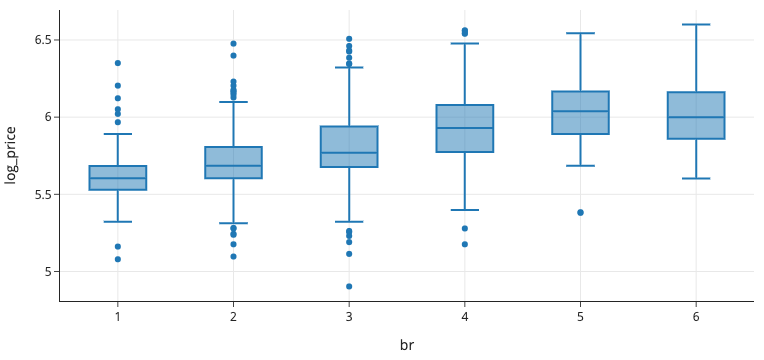

In [32]:
fig = px.box(sfh, x="br", y="log_price")

fig

After doing this transformation, we usually remove one of the new
feature columns from the design matrix.
If we don't do this, then the columns of the design matrix will be linearly
dependent after we add the intercept column, which means that we won't have
a useful interpretation for the model coefficients---we've left
this proof as an exercise.
We'll talk about what removing a column means later in this section.
For now, we'll simply remove the first one-hot encoded column.

In [302]:
enc = OneHotEncoder(
    # categories argument sets column order
    categories=[["Berkeley", "Lamorinda", "Piedmont", "Richmond"]],
    drop='first',
    sparse=False,
)

X_city = enc.fit_transform(sfh[['city']])
X_city

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [303]:
categories_city=["Lamorinda", "Piedmont", "Richmond"]

X_city_df = pd.DataFrame(X_city, columns=categories_city)

In [304]:
X_city_df

,Lamorinda,Piedmont,Richmond
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
...,...,...,...
2664,0.0,0.0,1.0
2665,0.0,0.0,1.0
2666,0.0,0.0,1.0


In [305]:
X_city_log = pd.concat([X1_log.reset_index(drop=True), X_city_df], axis=1)

In [306]:
X_city_log.drop(0)

,log_bsqft,Lamorinda,Piedmont,Richmond
1,3.14,0.0,0.0,0.0
2,3.31,0.0,0.0,0.0
3,2.96,0.0,0.0,0.0
...,...,...,...,...
2664,3.16,0.0,0.0,1.0
2665,3.47,0.0,0.0,1.0
2666,3.44,0.0,0.0,1.0


In [307]:
model_city_size = LinearRegression().fit(X_city_log, y_log_price)

In [308]:
model_city_size.intercept_

array([3.89])

In [309]:
model_city_size.coef_

array([[ 0.62,  0.09,  0.14, -0.15]])

In [310]:
print(f"R-square for BR indicators and log(size): {model_city_size.score(X_city_log, y_log_price):.2f}\n")

R-square for BR indicators and log(size): 0.79



In [311]:
import statsmodels.formula.api as smf

In [312]:
model_4 = smf.ols(formula='log_price ~ log_bsqft + city', data=sfh).fit()


In [313]:
print(model_4.params)

Intercept            3.89
city[T.Lamorinda]    0.09
city[T.Piedmont]     0.14
city[T.Richmond]    -0.15
log_bsqft            0.62
dtype: float64


In [314]:
model_5 = smf.ols(formula='log_price ~ log_bsqft + city - 1', data=sfh).fit()


In [315]:
print(model_5.params)

city[Berkeley]     3.89
city[Lamorinda]    3.98
city[Piedmont]     4.03
city[Richmond]     3.75
log_bsqft          0.62
dtype: float64


In [316]:
model_5.rsquared

0.7870009470761182

In [317]:
model_6 = smf.ols(formula='log_price ~ log_bsqft + city + log_bsqft:city', data=sfh).fit()


In [318]:
print(model_6.params)

Intercept                      3.99
city[T.Lamorinda]             -0.61
city[T.Piedmont]              -0.56
                               ... 
log_bsqft:city[T.Lamorinda]    0.21
log_bsqft:city[T.Piedmont]     0.21
log_bsqft:city[T.Richmond]    -0.05
Length: 8, dtype: float64


In [319]:
model_6.rsquared

0.7931404456356028

In [320]:
model_7 = smf.ols(formula='log_price ~ city + C(br)', data=sfh).fit()

In [321]:
print(model_7.params)

Intercept            5.73
city[T.Lamorinda]    0.11
city[T.Piedmont]     0.20
                     ... 
C(br)[T.4.0]         0.24
C(br)[T.5.0]         0.30
C(br)[T.6.0]         0.30
Length: 9, dtype: float64


In [322]:
model_7.rsquared

0.6751644900451701

In [323]:
model_8 = smf.ols(formula='log_price ~ city + C(br) + city:C(br)', data=sfh).fit()

In [324]:
print(model_8.params)

Intercept                         5.71
city[T.Lamorinda]                 0.20
city[T.Piedmont]                  0.31
                                  ... 
city[T.Lamorinda]:C(br)[T.6.0]   -0.13
city[T.Piedmont]:C(br)[T.6.0]    -0.09
city[T.Richmond]:C(br)[T.6.0]    -0.11
Length: 24, dtype: float64


In [325]:
model_8.rsquared

0.6814567418146753

In [210]:
predicted_5 = model_5.predict()
resids_5 = sfh['log_price'] - predicted_5

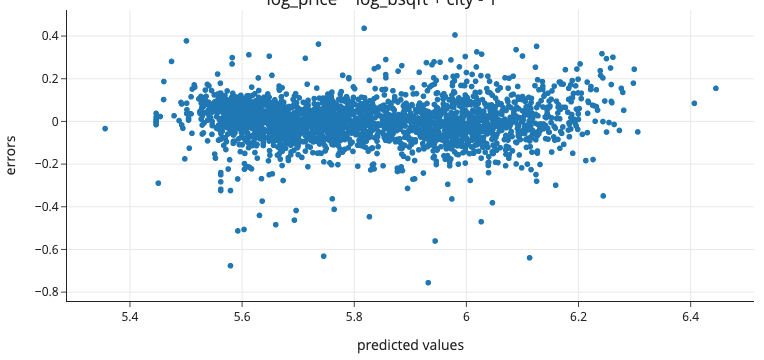

In [211]:
fig = px.scatter(x=predicted_5, y=resids_5, 
                labels={
                     "y": "errors",
                     "x": "predicted values"},
                title ="log_price ~ log_bsqft + city - 1")

fig

In [213]:
model_8 = smf.ols(formula='log_ppsf ~ log_bsqft + city + C(br)', data=sfh).fit()

In [214]:
print(model_8.params)

Intercept            3.85
city[T.Lamorinda]    0.08
city[T.Piedmont]     0.14
                     ... 
C(br)[T.5.0]         0.02
C(br)[T.6.0]        -0.04
log_bsqft           -0.36
Length: 10, dtype: float64


In [219]:
model_8.rsquared

0.473517046426117

In [218]:
predicted_8 = model_8.predict()
resids_8 = sfh['log_ppsf'] - predicted_8

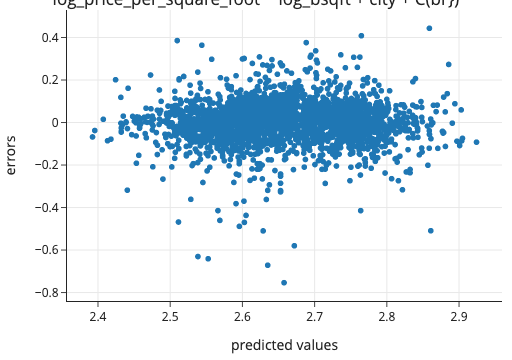

In [217]:
fig = px.scatter(x=predicted_8, y=resids_8, 
                labels={
                     "y": "errors",
                     "x": "predicted values"},
                title ="log_price_per_square_foot ~ log_bsqft + city + C(br})")

fig

After doing this transformation, we usually remove one of the new
feature columns from the design matrix.
If we don't do this, then the columns of the design matrix will be linearly
dependent after we add the intercept column, which means that we won't have
a useful interpretation for the model coefficients---we've left
this proof as an exercise.
We'll talk about what removing a column means later in this section.
For now, we'll simply remove the first one-hot encoded column.

Let's use a one-hot encoding on the Opportunity data.
We'll start with a subset of the data which just has the commuting zone's
AUM and its US Census region:

To do the encoding, we'll use the `scikit-learn` library's
`OneHotEncoder` class.

Now, we have a design matrix stored in the variable `X`. 
Since we've dropped the `Northeast` column from the design matrix,
the three resulting features represent the
`West`, `Midwest`, and `South` regions.
Let's fit a multiple linear model that predicts AUM from the one-hot encoded
regions.
Rather than defining our own functions, we'll use the `LinearRegression` class
from `scikit-learn`.

In [22]:
y = cz_df['aum']

model_region = LinearRegression().fit(X_region, y)

:::{note}

Although we've defined our own model fitting functions earlier in this chapter,
in practice we prefer to use a library like `scikit-learn` for modeling
since its code is highly optimized.
For example, the matrix multiplication code we wrote for fitting
multiple linear models runs very slowly when we have many observations.
`scikit-learn` can handle larger datasets without issue.

:::

Using one-hot encoding gives a natural interpretation for the model parameters.
The intercept of the model represents the expected outcome for the category
we removed from the design matrix.
In our case, we took out the `Northeast` column, so the model's intercept 
parameter represents the predicted AUM for the Northeast region.

:::{note}

One-hot encoding is also known as using *dummy variables*.
The term dummy variables is more common in statistics and econometrics.

:::

In this section, we introduced feature engineering, where we 
transform data before fitting a model.
We saw how using the one-hot encoding technique lets us fit linear models
on categorical data.
And, one-hot encoding gives us a natural interpretation for model parameters.
There are many other kinds of feature engineering, like using polynomial
terms.
In general, data scientists apply their domain knowledge to figure out
useful feature engineering steps for their models.

## The End

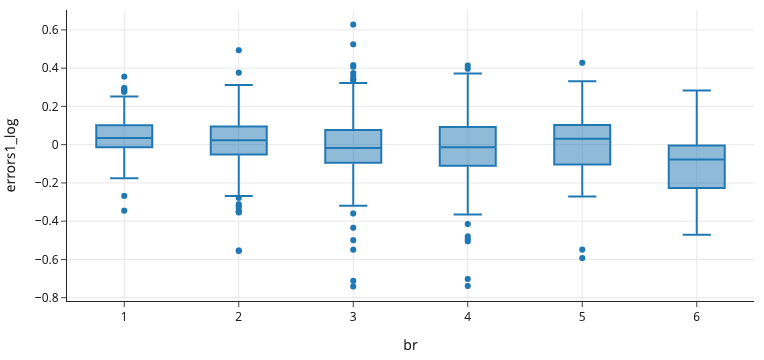

In [298]:
fig = px.box(sfh, x='br', y='errors1_log')

fig

Two other features that might help explain variations in house sale price are the number of bedrooms in the house and the location of the house. As we saw in {numref}`Chapter %s <ch:eda>`, side-by-side boxplots of price for, say, the different cities help us compare the distributions of price across cities. 

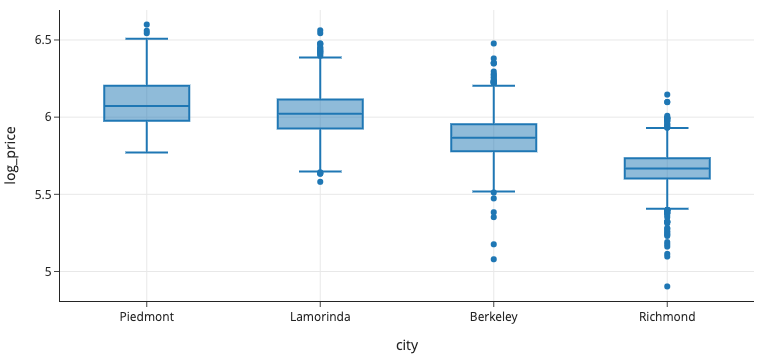

In [250]:
fig = px.box(sfh, x="city", y="log_price", 
             category_orders={"city":["Piedmont","Lamorinda","Berkeley", "Richmond"]})

fig

In [112]:
X3 = sfh[['log_lsqft', 'log_bsqft', 'br']]

model3 = LinearRegression().fit(X3, y_log_price)

In [115]:
print(f"R-square for 2-variable model: {model2.score(X2, y_log_price):.2f}\n",
     f"R-square for 3-variable model: {model3.score(X3, y_log_price):.2f}\n")

R-square for 2-variable model: 0.67
 R-square for 3-variable model: 0.68



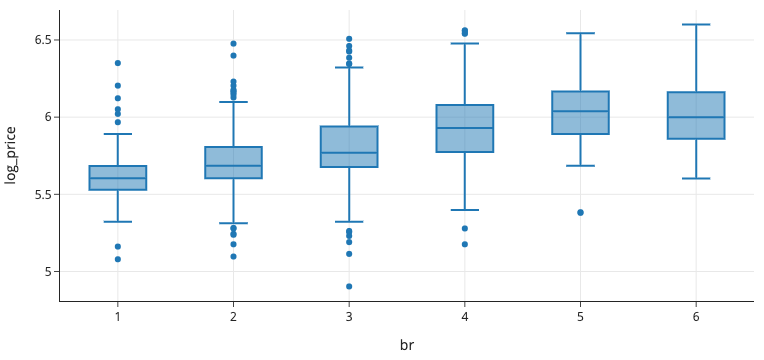

In [32]:
fig = px.box(sfh, x="br", y="log_price")

fig